## Семинар 7: "Методы оптимизации"

ФИО: Сербин Георгий Эдуардович

In [ ]:
from functools import partial

import numpy as np
import torch
from tqdm.auto import tqdm
from torch import nn
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.pyplot import cm
from matplotlib.colors import LogNorm
from matplotlib import animation
from mpl_toolkits import mplot3d
from matplotlib.gridspec import GridSpec
from torchvision import datasets, transforms
from IPython.display import HTML
%matplotlib inline
plt.rc('animation', html='html5')

На этом семинаре мы попробуем сравнить различные методы оптимизации: GD, Momentum, NAG, Adagrad, RMSProp, Adadelta, Adam.

### Часть 1: Реализация методов

Для всех экспериментов подберите параметры так, чтобы метод сошелся к ближайшему локальному минимуму. Все методы следует запускать из одной и той же точки.

In [ ]:
# https://github.com/dzlab/deepprojects/blob/master/visualization/Optimizers_in_Action.ipynb

def grid_samples(center=[0, 0], offset=5, size=100):
    range1 = np.linspace(center[0]-offset, center[0]+offset, size)
    range2 = np.linspace(center[1]-offset, center[1]+offset, size)
    return torch.from_numpy(np.stack(np.meshgrid(range1, range2))).float()


def mse(y, y_hat):
    return ((y - y_hat) ** 2).mean(axis=-1)


def msre(y, y_hat):
    return ((y - y_hat) ** 2).mean(axis=-1).sqrt()


def mae(y, y_hat):
    return ((y - y_hat).abs()).mean(axis=-1)


class LossAnimator:
    def __init__(self, X, y):
        self.X = X
        self.y = y
        self.size = len(X)

    def loss_func(self, W, loss):
        shape = W.shape
        return loss((self.X @ W.view(shape[0], -1)).T, self.y).view(shape[1:])

    def plot_loss_funcs(self, weights, fcts, titles, view=(20, 50)):
        num_fcts = len(fcts)
        fig = plt.figure(figsize=(7 * num_fcts,7))
        for i in range(num_fcts):
            loss = self.loss_func(weights, loss=fcts[i])
            ax = fig.add_subplot(1, num_fcts, i+1, projection='3d')
            ax.plot_surface(*weights, loss, cmap='viridis')
            ax.set_xlabel('w0'); ax.set_ylabel('w1'); ax.set_zlabel('Loss')
            ax.set_title(titles[i])
            ax.view_init(*view)

    def _init_animation(self, epochs, train_data):
        self.train_data = train_data
        self.epochs = epochs
        self.nmethods = len(train_data)

        weights = grid_samples(offset=5)

        max_loss = max([data['losses'].max() for data in train_data.values()])
        loss_curve = self.loss_func(weights, loss=mse)
        colors = cm.rainbow(np.linspace(0, 1, self.nmethods))


        self.fig = plt.figure(figsize=(14, 8))
        self.gs = GridSpec(2, 2, width_ratios=[1, 2.5])

        self.ax0 = self.fig.add_subplot(self.gs[0,0])
        self.lines0 = {
            name: self.ax0.plot([], [], c=c, label=name)[0]
            for name, c in zip(train_data.keys(), colors)
        }
        self.ax0.scatter(self.X[:,0], self.y, c='orange', label='Ground truth')
        self.ax0.set_ylim(self.y.min(), self.y.max())
        self.ax0.set_title('Ground truth & Model', fontsize=16)
        self.ax0.legend(loc='lower right')

        self.ax1 = self.fig.add_subplot(self.gs[:,1], projection='3d')
        self.ax1.plot_surface(*weights, loss_curve-0.5, cmap='viridis', alpha=0.8)
        self.ax1.view_init(50, 70)
        self.lines1 = {
            name: self.ax1.plot3D([], [], [], c=c, marker='o', alpha=0.9, label=name)[0]
            for name, c in zip(train_data.keys(), colors)
        }
        self.ax1.set_title('Loss', fontsize=16, pad=20)
        self.ax1.set_xlabel('w0')
        self.ax1.set_ylabel('w1')
        self.ax1.set_zlabel('Loss')
        self.ax1.legend()

        self.ax2 = self.fig.add_subplot(self.gs[1,0])
        self.lines2 = {
            name: self.ax2.plot([], [], c=c, label=name)[0]
            for name, c in zip(train_data.keys(), colors)
        }
        self.ax2.set_title('Loss', fontsize=16)
        self.ax2.set_ylabel('loss')
        self.ax2.set_ybound(0, max_loss)
        self.ax2.set_xlim(0, epochs)
        self.ax2.legend(loc='center right')

        self.fig.tight_layout()
        self.fig.subplots_adjust(top=0.85)

        plt.close()

        return self.fig

    def _animate(self, i):
        steps = np.arange(i+1)
        left = max(0, i-20)
        for name, data in self.train_data.items():
            # plot ground truth & model
            self.lines0[name].set_data(self.X[:, 0], self.X @ data['weights'][i])

            # plot loss (output of the sampling)
            self.lines1[name].set_data(data['weights'][left:i+1, 0], data['weights'][left:i+1, 1])
            self.lines1[name].set_3d_properties(data['losses'][left:i+1])

            self.lines2[name].set_data(steps, data['losses'][:i+1])

        self.fig.suptitle(f'Epoch: {i}/{self.epochs}', fontsize=22)

    def animate(self, epochs, train_data, step_skip=1):
        self._init_animation(epochs, train_data)
        anim = animation.FuncAnimation(self.fig, self._animate, frames=range(0, epochs, step_skip), interval=100 * step_skip)
        return HTML(anim.to_html5_video())

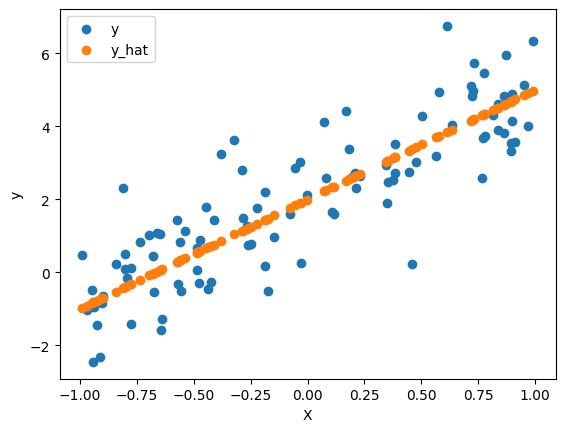

In [ ]:
size = 100
X = torch.ones(size, 2)
X[:, 0].uniform_(-1., 1)

y_hat = 3 * X[:, 0] + 2
y = y_hat + torch.randn(size)

loss_animator = LossAnimator(X, y)

plt.scatter(loss_animator.X[:,0], loss_animator.y, label='y');
plt.scatter(loss_animator.X[:,0], y_hat, label='y_hat');
plt.xlabel('X')
plt.ylabel('y')
plt.legend()

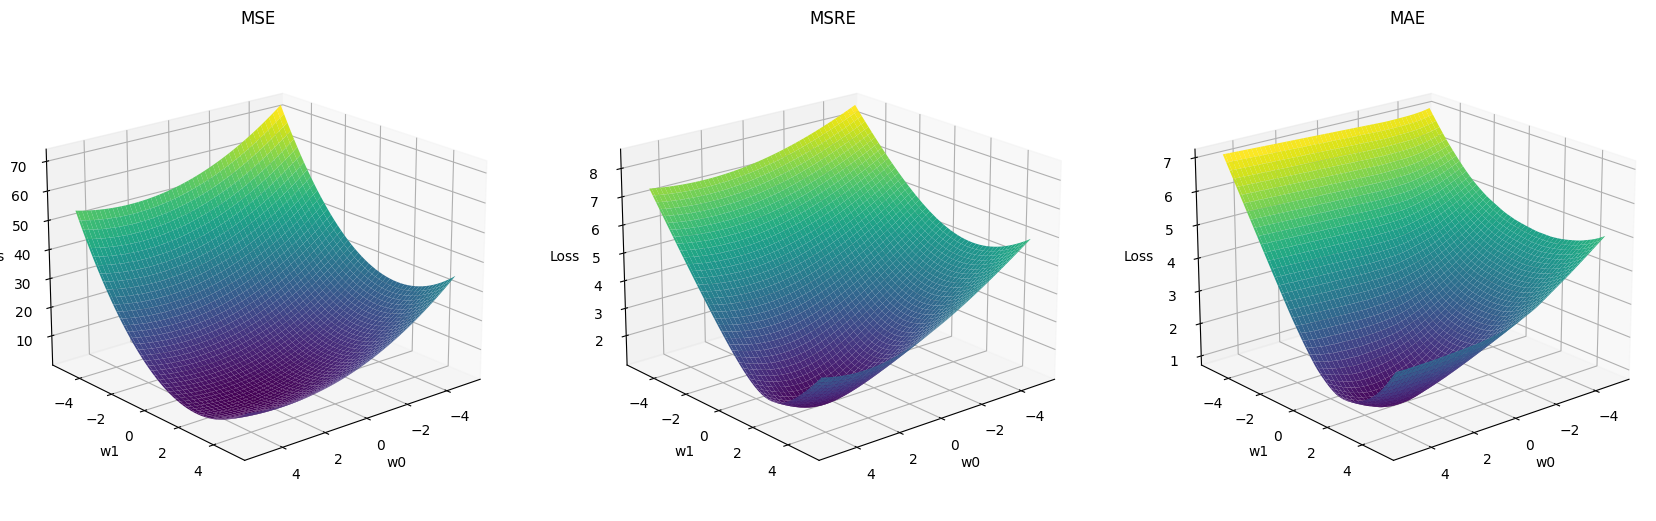

In [ ]:
weights = grid_samples()
loss_animator.plot_loss_funcs(weights, [mse, msre, mae], ['MSE', 'MSRE', 'MAE'])

<i> 1.1 Реализуйте методы SGD, Momentum, NAG, Adagrad, Adadelta, Adam.</i> **(1 балл)**

In [ ]:
class Optimizer:
    def __init__(self, params):
        self.params = list(params)

    def zero_grad(self):
        for param in self.params:
            if param.grad is not None:
                param.grad.detach_()
                param.grad.zero_()

    def pre_step(self):
        pass

    def step(self):
        pass

    def update_param(self, p):
        raise NotImplementedError()


In [ ]:
def optimize_function(fn, optim, optim_args, start_point, num_iter = 50):
    weigths = nn.Parameter(torch.FloatTensor(start_point), requires_grad=True)

    optim = optim(params=[weigths], **optim_args)
    points = []
    losses = []
    for i in range(num_iter):
        if hasattr(optim, 'pre_step'):
            optim.pre_step()
        loss = fn(weigths)
        points.append(weigths.data.detach().clone())
        losses.append(loss.item())
        loss.backward()
        optim.step()
        optim.zero_grad()
    points = torch.stack(points, axis=0)
    losses = torch.FloatTensor(losses)
    return points, losses


In [ ]:
def compare_optimizers(
    loss_animator,
    fn,
    optim_list,
    start_point,
    num_iter = 50,
    step_skip = 1
):
    data = {}
    loss_func = partial(loss_animator.loss_func, loss=fn)
    for name, optim, args in optim_list:
        points, losses = optimize_function(loss_func, optim, args, start_point, num_iter)
        data[name] = {
            'weights': points,
            'losses': losses,
        }

    return loss_animator.animate(num_iter, data, step_skip=step_skip)

SGD

In [ ]:
class SGD(Optimizer):
    def __init__(self, params, lr=1e-2):
        super().__init__(params)
        self.lr = lr

    def step(self):
        with torch.no_grad():
            for p in self.params:
                if p.grad is None:
                    continue
                p -= self.lr * p.grad


Momentum

In [ ]:
class Momentum(Optimizer):
    def __init__(self, params, lr=1e-2, gamma = 0.9):
        super().__init__(params)
        self.lr = lr
        self.gamma = gamma
        self.momentum = [torch.zeros_like(p) for p in self.params]


    def step(self):
        with torch.no_grad():
            for i, p in enumerate(self.params):
                if p.grad is None:
                    continue
                self.momentum[i] = self.gamma * self.momentum[i] + self.lr * p.grad
                p -= self.momentum[i]

Nesterov Accelerated Gradient

In [ ]:
class NAG(Optimizer):
    def __init__(self, params, lr=1e-2, gamma = 0.9):
        super().__init__(params)
        self.lr = lr
        self.gamma = gamma
        self.momentum = [torch.zeros_like(p) for p in self.params]

    def step(self):
        with torch.no_grad():
            for i, p in enumerate(self.params):
                if p.grad is None:
                    continue
                prev_momentum = self.momentum[i]
                self.momentum[i] = self.gamma * self.momentum[i] + self.lr * p.grad
                p -= (1+self.gamma) * self.momentum[i] - self.gamma * prev_momentum

AdaGrad

In [ ]:
class AdaGrad(Optimizer):
    def __init__(self, params, lr=1e-2, eps = 1e-8):
        super().__init__(params)
        self.lr = lr
        self.eps = eps
        self.G = [torch.zeros_like(p) for p in self.params]

    def step(self):
        with torch.no_grad():
            for i, p in enumerate(self.params):
                if p.grad is None:
                    continue
                self.G[i] += p.grad ** 2
                p -= self.lr / torch.sqrt(self.G[i] + self.eps) * p.grad

RMSProp

In [ ]:
class RMSProp(Optimizer):
    def __init__(self, params, lr=1e-2, eps = 1e-8, gamma = 0.9):
        super().__init__(params)
        self.lr = lr
        self.eps = eps
        self.G = [torch.zeros_like(p) for p in self.params]
        self.gamma = 0.9

    def step(self):
        with torch.no_grad():
            for i, p in enumerate(self.params):
                if p.grad is None:
                    continue
                self.G[i] = self.gamma * self.G[i] + (1-self.gamma) * p.grad ** 2
                p -= self.lr / torch.sqrt(self.G[i] + self.eps) * p.grad

Adadelta

In [ ]:
class Adadelta(Optimizer):
    def __init__(self, params, eps = 1e-8, gamma = 0.9, O0 = 1e-1):
        super().__init__(params)
        self.eps = eps
        self.G = [torch.zeros_like(p) for p in self.params]
        self.O = [O0 * torch.ones_like(p) for p in self.params]
        self.gamma = 0.9

    def step(self):
        with torch.no_grad():
            for i, p in enumerate(self.params):
                if p.grad is None:
                    continue
                self.G[i] = self.gamma * self.G[i] + (1-self.gamma) * p.grad ** 2
                deltaP = torch.sqrt(self.O[i] + self.eps) / torch.sqrt(self.G[i] + self.eps) * p.grad
                p -= deltaP
                self.O[i] = self.gamma * self.O[i] + (1-self.gamma) * deltaP ** 2

Adaptive Moment Estimation (Adam)

In [ ]:
class Adam(Optimizer):
    def __init__(self, params, lr = 1e-2, beta1 = 0.9, beta2 = 0.9, eps = 1e-8):
        super().__init__(params)
        self.momentum = [torch.zeros_like(p) for p in self.params]
        self.dumping = [torch.zeros_like(p) for p in self.params]
        self.lr = lr
        self.beta1 = beta1
        self.beta2 = beta2
        self.eps = eps

    def step(self):
        with torch.no_grad():
            for i, p in enumerate(self.params):
                if p.grad is None:
                    continue
                self.momentum[i] = self.beta1 * self.momentum[i] + (1-self.beta1) * p.grad
                self.dumping[i] = self.beta2 * self.dumping[i] + (1-self.beta2) * p.grad ** 2
                p -= self.lr / (torch.sqrt(self.dumping[i] / (1-self.beta2))+self.eps) * self.momentum[i] / (1-self.beta1)

In [ ]:
from functools import partial

points, losses = optimize_function(partial(loss_animator.loss_func, loss=mse), SGD, {'lr': 1e-1}, start_point=[-20, -20], num_iter=100)

<i1> 1.2 Сравните реализованные методы на предложенном примере **(1 балл)**

In [ ]:
compare_optimizers(
    loss_animator,
    mse,
    [
        ['SGD', SGD, {'lr': 1e-1}],
        ['Momentum', Momentum, {'lr': 1e-1}],
        ['NAG', NAG, {'lr': 1e-1}],
        ['AdaGrad', AdaGrad, {'lr': 1e-1}],
        ['RMSProp', RMSProp, {'lr': 1e-1}],
        ['Adadelta', Adadelta, {'O0': 1e-1}],
        ['Adam', Adam, {'lr': 1e-1}],
    ],
    start_point=[-4, -4],
    num_iter=100
)

/usr/local/lib/python3.10/dist-packages/mpl_toolkits/mplot3d/proj3d.py:210: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  return np.array([xs, ys, zs, np.ones_like(xs)])
/usr/local/lib/python3.10/dist-packages/mpl_toolkits/mplot3d/proj3d.py:210: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([xs, ys, zs, np.ones_like(xs)])


Для выбранных гиперпараметров и функции потерь хуже всех отрабатывает AdaGrad (шаг быстро становится очень маленьким и метод не доходит до точки минимума). Метод моментов отрабатывает чуть хуже метода градиентов Нестерова (лосс совершает более сильные колебания). Лучше всех сработал метод Adadelta (за короткое число шагов лос упал до минимума и далее не менялся). Методу Adam понадобилось большее число итераций по сравнению с SGD чтобы дойти до точки минимума + даже на 60-й итерации у него продолжаются колебания (можно видеть на графике с прямыми)

###  Часть 2: Обучение нейронной сети

<i> 2.1 Сравните графики обучения для полносвязной нейросети на методах Adam, Adagrad, AdaDelta и SGD (на MNIST). Для обучения используйте оптимизаторы из первой части, а не из pytorch. </i> **(2 балла)**

In [ ]:
!wget www.di.ens.fr/~lelarge/MNIST.tar.gz
!tar -zxvf MNIST.tar.gz

--2023-10-05 17:49:42--  http://www.di.ens.fr/~lelarge/MNIST.tar.gz
Resolving www.di.ens.fr (www.di.ens.fr)... 129.199.99.14
Connecting to www.di.ens.fr (www.di.ens.fr)|129.199.99.14|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://www.di.ens.fr/~lelarge/MNIST.tar.gz [following]
--2023-10-05 17:49:43--  https://www.di.ens.fr/~lelarge/MNIST.tar.gz
Connecting to www.di.ens.fr (www.di.ens.fr)|129.199.99.14|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/x-gzip]
Saving to: ‘MNIST.tar.gz’

MNIST.tar.gz            [         <=>        ]  33.20M  16.8MB/s    in 2.0s    

2023-10-05 17:49:45 (16.8 MB/s) - ‘MNIST.tar.gz’ saved [34813078]

MNIST/
MNIST/raw/
MNIST/raw/train-labels-idx1-ubyte
MNIST/raw/t10k-labels-idx1-ubyte.gz
MNIST/raw/t10k-labels-idx1-ubyte
MNIST/raw/t10k-images-idx3-ubyte.gz
MNIST/raw/train-images-idx3-ubyte
MNIST/raw/train-labels-idx1-ubyte.gz
MNIST/raw/t10k-images-idx3-ubyte
MNIST/raw/tra

In [ ]:
default_transform = transforms.Compose([
   transforms.ToTensor(),
   transforms.Normalize((0.1307,), (0.3081,))
])

rotate_transform = transforms.RandomRotation((-15,15))
train_transform = transforms.Compose([
                       default_transform,
                       rotate_transform
                       ])

train_dataset = datasets.MNIST('.', train=True, download=True, transform=train_transform)
val_dataset = datasets.MNIST('.', train=False, transform=default_transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=True)

In [ ]:
from IPython.display import clear_output
import torch.nn.functional as F

def train(model, optimizer, n_epochs=5, loss = None):
    if loss is None:
        loss = F.cross_entropy

    train_loss_epochs = []
    test_loss_epochs = []
    train_accuracy_epochs = []
    test_accuracy_epochs = []

    for epoch in range(n_epochs):
        losses = []
        accuracies = []
        # обучение
        for x_train, y_train in tqdm(train_loader):
            y_pred = model(x_train)
            loss_batch = loss(y_pred, y_train)
            loss_batch.backward()
            optimizer.step()
            optimizer.zero_grad()
            losses.append(loss_batch.detach().numpy())
            accuracies.extend((torch.argmax(y_pred, dim=-1) == y_train).numpy().tolist())

        train_loss_epochs.append(np.mean(losses))
        train_accuracy_epochs.append(np.mean(accuracies))

        # валидация
        losses = []
        accuracies = []
        with torch.no_grad():
            for x_val, y_val in tqdm(val_loader):
                y_pred = model(x_val)
                loss_batch = loss(y_pred, y_val)
                losses.append(loss_batch.numpy())
                accuracies.extend((torch.argmax(y_pred, dim=-1) == y_val).numpy().tolist())
        test_loss_epochs.append(np.mean(losses))
        test_accuracy_epochs.append(np.mean(accuracies))

        print(f'Epoch: {epoch}, loss: {np.mean(losses)}, accuracy: {np.mean(accuracies)}')
    clear_output(True)
    return test_loss_epochs, test_accuracy_epochs, train_loss_epochs, train_accuracy_epochs

In [ ]:
model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(28*28, 128),
    nn.ReLU(),
    nn.Linear(128, 10)
)

In [ ]:
def reset_parameters(model):
    for layer in model.children():
        if hasattr(layer, 'reset_parameters'):
            layer.reset_parameters()

In [ ]:
reset_parameters(model)
optimizer = SGD(model.parameters())
ts_loss_SGD, ts_accuracy_SGD, tr_loss_SGD, tr_accuracy_SGD = train(model, optimizer)


reset_parameters(model)
optimizer = Momentum(model.parameters())
ts_loss_Momentum, ts_accuracy_Momentum, tr_loss_Momentum, tr_accuracy_Momentum = train(model, optimizer)

reset_parameters(model)
optimizer = NAG(model.parameters())
ts_loss_NAG, ts_accuracy_NAG, tr_loss_NAG, tr_accuracy_NAG = train(model, optimizer)

reset_parameters(model)
optimizer = AdaGrad(model.parameters())
ts_loss_AdaGrad, ts_accuracy_AdaGrad, tr_loss_AdaGrad, tr_accuracy_AdaGrad = train(model, optimizer)

reset_parameters(model)
optimizer = RMSProp(model.parameters())
ts_loss_RMSProp, ts_accuracy_RMSProp, tr_loss_RMSProp, tr_accuracy_RMSProp = train(model, optimizer)

reset_parameters(model)
optimizer = Adadelta(model.parameters(), O0 = 1e-3)
ts_loss_Adadelta, ts_accuracy_Adadelta, tr_loss_Adadelta, tr_accuracy_Adadelta = train(model, optimizer)

reset_parameters(model)
optimizer = Adam(model.parameters(), lr = 1e-3)
ts_loss_Adam, ts_accuracy_Adam, tr_loss_Adam, tr_accuracy_Adam = train(model, optimizer)

  0%|          | 0/1875 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

Epoch: 0, loss: 0.17391540110111237, accuracy: 0.9565


  0%|          | 0/1875 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

Epoch: 1, loss: 0.19395601749420166, accuracy: 0.9601


  0%|          | 0/1875 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

Epoch: 2, loss: 0.18871551752090454, accuracy: 0.9662


  0%|          | 0/1875 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

Epoch: 3, loss: 0.2234204113483429, accuracy: 0.9641


  0%|          | 0/1875 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

Epoch: 4, loss: 0.23318634927272797, accuracy: 0.9599


### На трейне

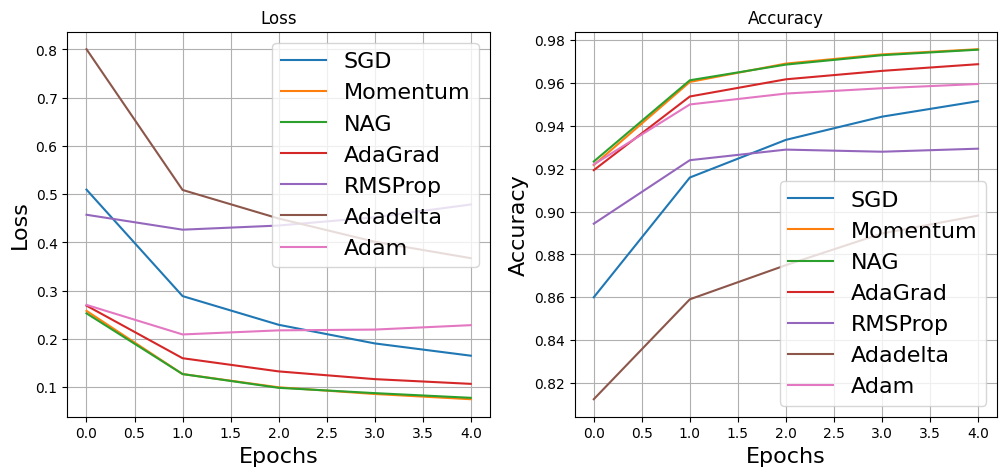

In [ ]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.title('Loss')
plt.plot(tr_loss_SGD, label='SGD')
plt.plot(tr_loss_Momentum, label='Momentum')
plt.plot(tr_loss_NAG, label='NAG')
plt.plot(tr_loss_AdaGrad, label='AdaGrad')
plt.plot(tr_loss_RMSProp, label='RMSProp')
plt.plot(tr_loss_Adadelta, label='Adadelta')
plt.plot(tr_loss_Adam, label='Adam')
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.legend(loc=0, fontsize=16)
plt.grid()

plt.subplot(1, 2, 2)
plt.title('Accuracy')
plt.plot(tr_accuracy_SGD, label='SGD')
plt.plot(tr_accuracy_Momentum, label='Momentum')
plt.plot(tr_accuracy_NAG, label='NAG')
plt.plot(tr_accuracy_AdaGrad, label='AdaGrad')
plt.plot(tr_accuracy_RMSProp, label='RMSProp')
plt.plot(tr_accuracy_Adadelta, label='Adadelta')
plt.plot(tr_accuracy_Adam, label='Adam')
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Accuracy', fontsize=16)
plt.legend(loc=0, fontsize=16)
plt.grid()

plt.show()

### На тесте

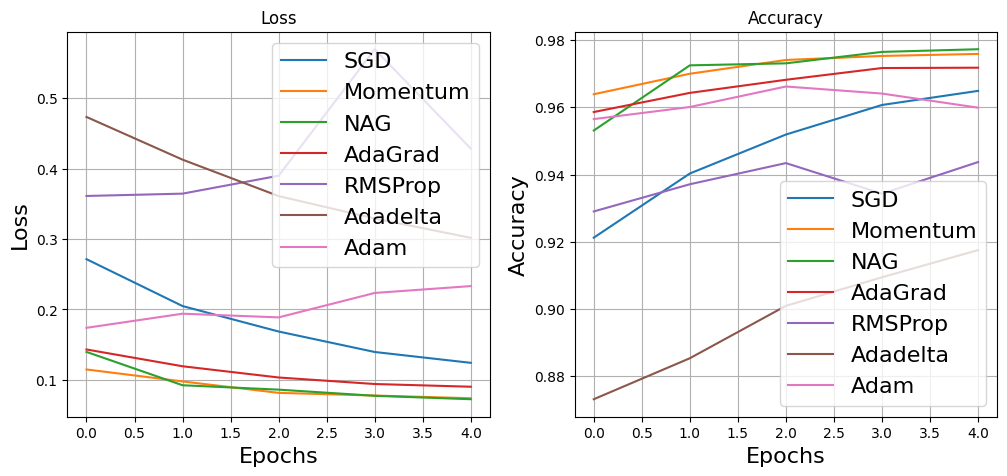

In [ ]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.title('Loss')
plt.plot(ts_loss_SGD, label='SGD')
plt.plot(ts_loss_Momentum, label='Momentum')
plt.plot(ts_loss_NAG, label='NAG')
plt.plot(ts_loss_AdaGrad, label='AdaGrad')
plt.plot(ts_loss_RMSProp, label='RMSProp')
plt.plot(ts_loss_Adadelta, label='Adadelta')
plt.plot(ts_loss_Adam, label='Adam')
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.legend(loc=0, fontsize=16)
plt.grid()

plt.subplot(1, 2, 2)
plt.title('Accuracy')
plt.plot(ts_accuracy_SGD, label='SGD')
plt.plot(ts_accuracy_Momentum, label='Momentum')
plt.plot(ts_accuracy_NAG, label='NAG')
plt.plot(ts_accuracy_AdaGrad, label='AdaGrad')
plt.plot(ts_accuracy_RMSProp, label='RMSProp')
plt.plot(ts_accuracy_Adadelta, label='Adadelta')
plt.plot(ts_accuracy_Adam, label='Adam')
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Accuracy', fontsize=16)
plt.legend(loc=0, fontsize=16)
plt.grid()

plt.show()

Хуже всего отработал метод Adadelta, который на прошлой задаче оказался самым удачным. Вероятно были неудачно подобраны гиперпараметры. Лучше всех справился метод моментов и градиентов Нестерова

<i> 2.2 Сравните графики обучения для сверточной нейросети на методах Adam, Adagrad, AdaDelta и SGD. </i> **(1 балл)**

In [ ]:
model = nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=16, kernel_size=8),  # grayscale
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=4),   # сократим изображение в 4 раза по каждой из сторон
    nn.Flatten(),
    nn.Linear(25*16, 128),
    nn.ReLU(),
    nn.Linear(128, 10)
)

In [ ]:
reset_parameters(model)
optimizer = SGD(model.parameters())
ts_loss_SGD, ts_accuracy_SGD, tr_loss_SGD, tr_accuracy_SGD = train(model, optimizer)


reset_parameters(model)
optimizer = Momentum(model.parameters())
ts_loss_Momentum, ts_accuracy_Momentum, tr_loss_Momentum, tr_accuracy_Momentum = train(model, optimizer)

reset_parameters(model)
optimizer = NAG(model.parameters())
ts_loss_NAG, ts_accuracy_NAG, tr_loss_NAG, tr_accuracy_NAG = train(model, optimizer)

reset_parameters(model)
optimizer = AdaGrad(model.parameters())
ts_loss_AdaGrad, ts_accuracy_AdaGrad, tr_loss_AdaGrad, tr_accuracy_AdaGrad = train(model, optimizer)

reset_parameters(model)
optimizer = RMSProp(model.parameters())
ts_loss_RMSProp, ts_accuracy_RMSProp, tr_loss_RMSProp, tr_accuracy_RMSProp = train(model, optimizer)

reset_parameters(model)
optimizer = Adadelta(model.parameters(), O0 = 1e-3)
ts_loss_Adadelta, ts_accuracy_Adadelta, tr_loss_Adadelta, tr_accuracy_Adadelta = train(model, optimizer)

reset_parameters(model)
optimizer = Adam(model.parameters(), lr = 1e-3)
ts_loss_Adam, ts_accuracy_Adam, tr_loss_Adam, tr_accuracy_Adam = train(model, optimizer)

  0%|          | 0/1875 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

Epoch: 0, loss: 0.08677835762500763, accuracy: 0.9744


  0%|          | 0/1875 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

Epoch: 1, loss: 0.06904460489749908, accuracy: 0.9798


  0%|          | 0/1875 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

Epoch: 2, loss: 0.08489024639129639, accuracy: 0.9828


  0%|          | 0/1875 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

Epoch: 3, loss: 0.08170425891876221, accuracy: 0.9805


  0%|          | 0/1875 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

Epoch: 4, loss: 0.0776633769273758, accuracy: 0.9816


### На трейне

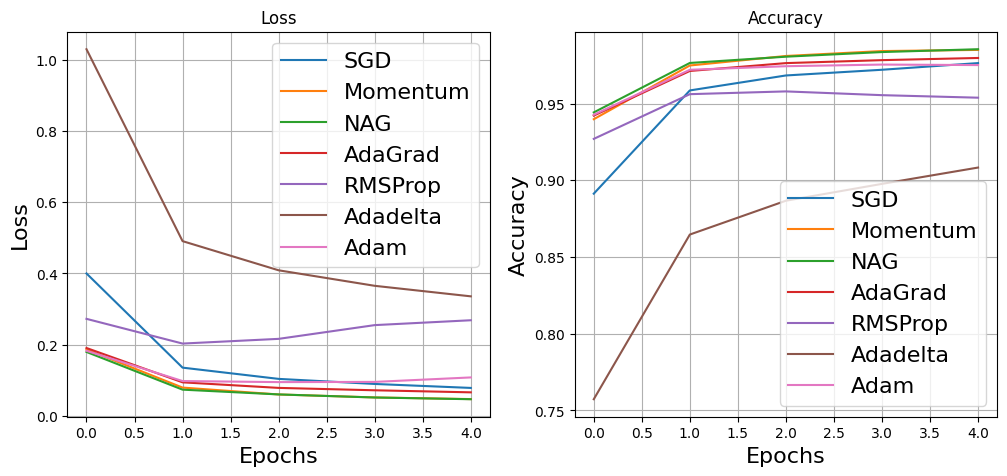

In [ ]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.title('Loss')
plt.plot(tr_loss_SGD, label='SGD')
plt.plot(tr_loss_Momentum, label='Momentum')
plt.plot(tr_loss_NAG, label='NAG')
plt.plot(tr_loss_AdaGrad, label='AdaGrad')
plt.plot(tr_loss_RMSProp, label='RMSProp')
plt.plot(tr_loss_Adadelta, label='Adadelta')
plt.plot(tr_loss_Adam, label='Adam')
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.legend(loc=0, fontsize=16)
plt.grid()

plt.subplot(1, 2, 2)
plt.title('Accuracy')
plt.plot(tr_accuracy_SGD, label='SGD')
plt.plot(tr_accuracy_Momentum, label='Momentum')
plt.plot(tr_accuracy_NAG, label='NAG')
plt.plot(tr_accuracy_AdaGrad, label='AdaGrad')
plt.plot(tr_accuracy_RMSProp, label='RMSProp')
plt.plot(tr_accuracy_Adadelta, label='Adadelta')
plt.plot(tr_accuracy_Adam, label='Adam')
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Accuracy', fontsize=16)
plt.legend(loc=0, fontsize=16)
plt.grid()

plt.show()

### На тесте

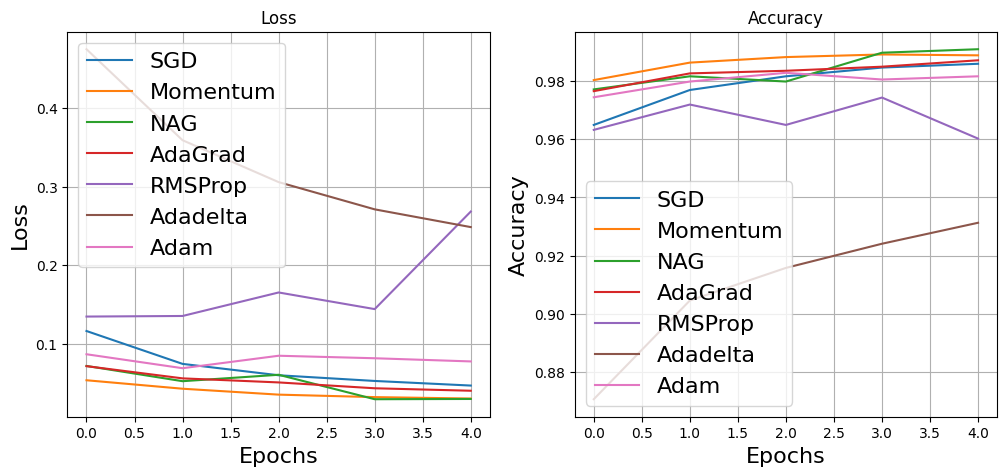

In [ ]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.title('Loss')
plt.plot(ts_loss_SGD, label='SGD')
plt.plot(ts_loss_Momentum, label='Momentum')
plt.plot(ts_loss_NAG, label='NAG')
plt.plot(ts_loss_AdaGrad, label='AdaGrad')
plt.plot(ts_loss_RMSProp, label='RMSProp')
plt.plot(ts_loss_Adadelta, label='Adadelta')
plt.plot(ts_loss_Adam, label='Adam')
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.legend(loc=0, fontsize=16)
plt.grid()

plt.subplot(1, 2, 2)
plt.title('Accuracy')
plt.plot(ts_accuracy_SGD, label='SGD')
plt.plot(ts_accuracy_Momentum, label='Momentum')
plt.plot(ts_accuracy_NAG, label='NAG')
plt.plot(ts_accuracy_AdaGrad, label='AdaGrad')
plt.plot(ts_accuracy_RMSProp, label='RMSProp')
plt.plot(ts_accuracy_Adadelta, label='Adadelta')
plt.plot(ts_accuracy_Adam, label='Adam')
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Accuracy', fontsize=16)
plt.legend(loc=0, fontsize=16)
plt.grid()

plt.show()

Для сверточной сети картина оказалось аналогична полносвязной. Наименее эффективным оказался Adadelta. Наиболее -- метод моментов и метод градиентов нестерова. Можно предположить, что задача плохо обусловлена, линии уровня функции потерь "вытянуты" вдоль некоторого направления, поэтому методы с моментами оказываются более эффектвиными

#### Feedback (опционально)

Здесь вы можете оставить список опечаток из лекции или семинара:

Здесь вы можете оставить комментарии по лекции или семинару: